### Business Problem
###### In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.
###### Date: 22.01.2025
###### Author: Eric Seso

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import plotly.graph_objects as go
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Read data

In [ ]:
df_train  =  pd.read_csv('train.csv', parse_dates=['date'])
df_oil = pd.read_csv('oil.csv', parse_dates=['date'])
df_sample_submission = pd.read_csv('sample_submission.csv')
df_stores = pd.read_csv('stores.csv')
df_test = pd.read_csv('test.csv', parse_dates=['date'])
df_transaction = pd.read_csv('transactions.csv', parse_dates=['date'])
df_holidays_events = pd.read_csv('holidays_events.csv', parse_dates=['date'])

### Transform Data
#### Create joined dataset

In [3]:
print(df_train.columns)
print(df_oil.columns)
print(df_sample_submission.columns)
print(df_stores.columns)
print(df_test.columns)
print(df_transaction.columns)
print(df_holidays_events.columns)

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')
Index(['date', 'dcoilwtico'], dtype='object')
Index(['id', 'sales'], dtype='object')
Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')
Index(['id', 'date', 'store_nbr', 'family', 'onpromotion'], dtype='object')
Index(['date', 'store_nbr', 'transactions'], dtype='object')
Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')


#### Visualizing Sales for a Specific Product Family in a Specific Store During Holidays

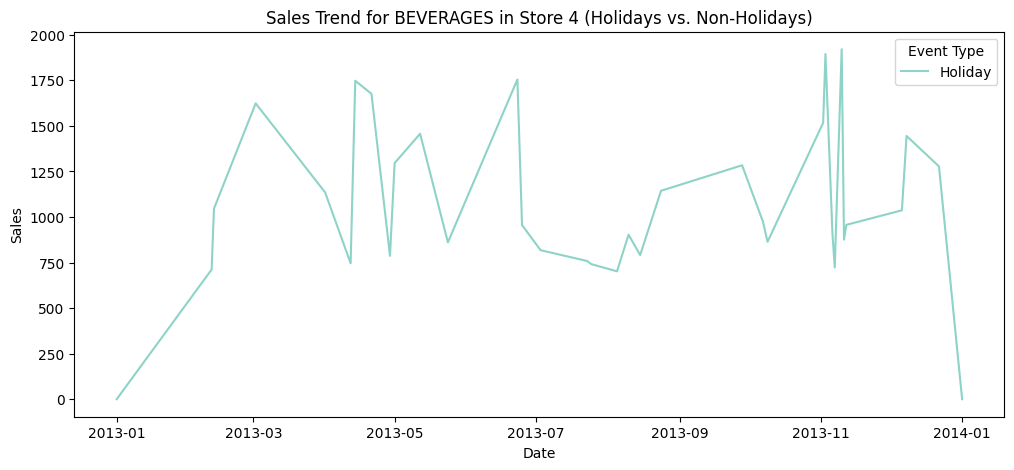

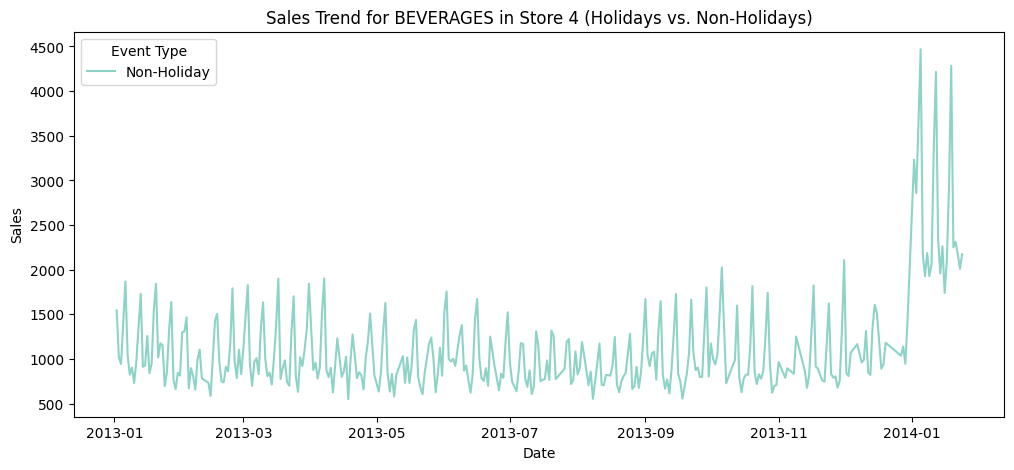

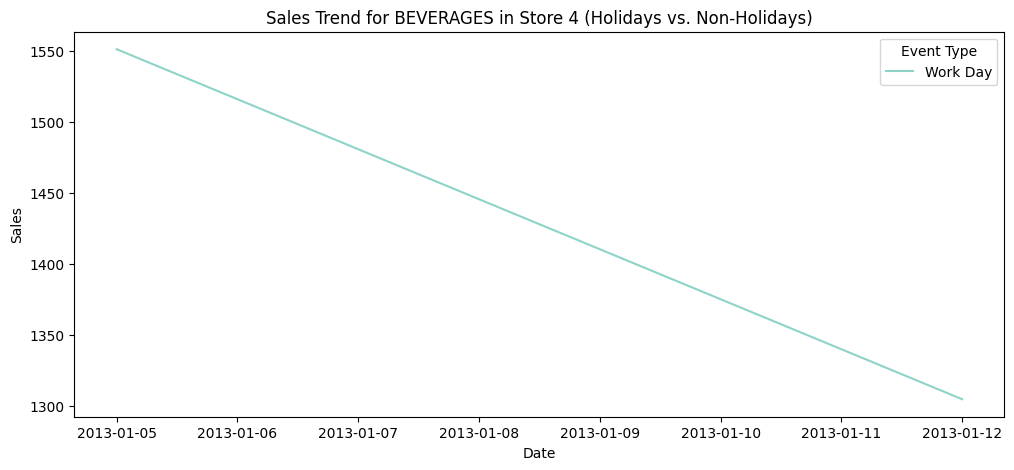

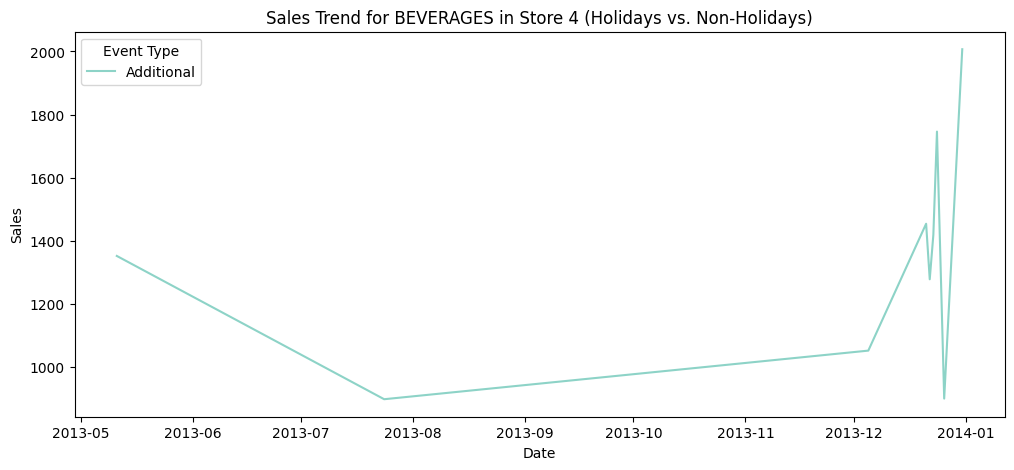

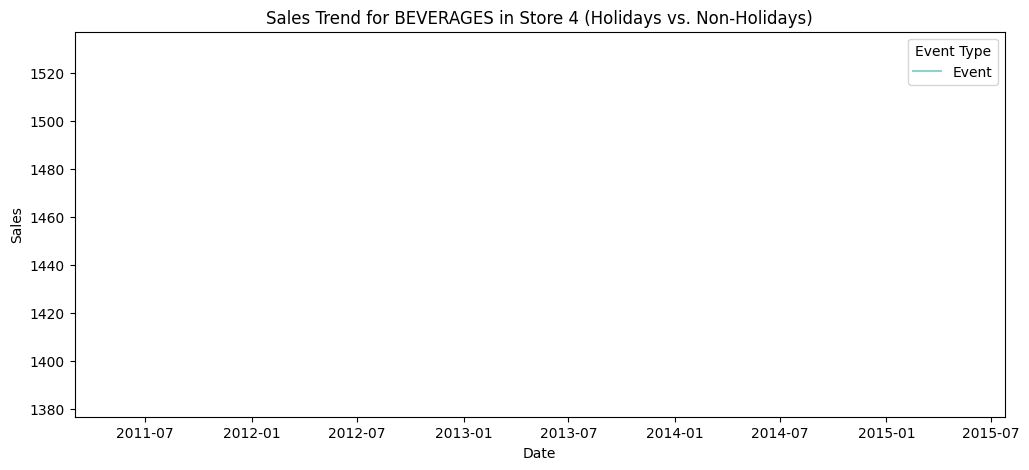

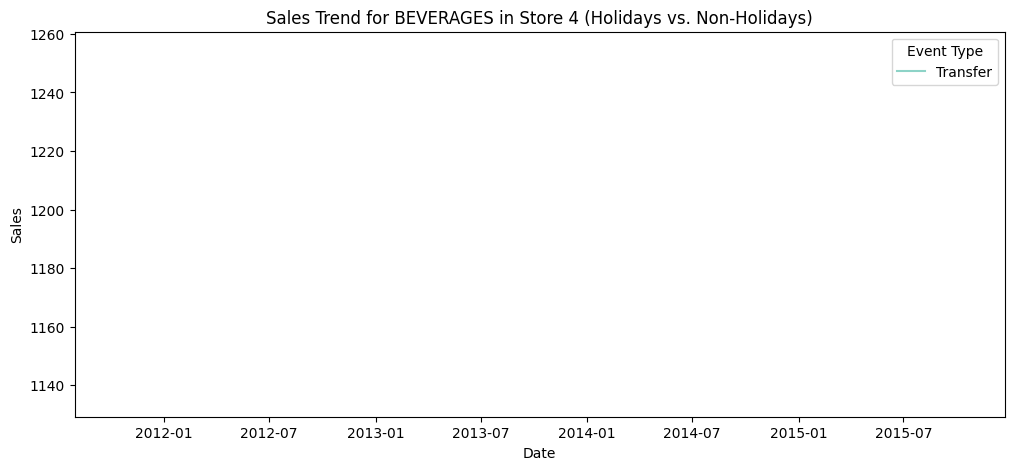

In [4]:
# Merge train_data with holiday events on 'date'
df = df_train.merge(df_holidays_events[['date', 'type', 'locale', 'locale_name']], on='date', how='left')
# Fill NaN holidays as "Non-Holiday"
df['type'] = df['type'].fillna("Non-Holiday")
# Choose a specific store and product family
store_nbr = 4  # Change this to any store number
product_family = "BEVERAGES"  # Change this to any product category
for type_event in df['type'].unique():
    df_filtered = df[(df['store_nbr'] == store_nbr) & (df['family'] == product_family) & (df['type'] ==  type_event )]
    plt.figure(figsize=(12, 5))

    # Plot sales over time
    sns.lineplot(data=df_filtered, x='date', y='sales', hue='type', palette="Set3")

    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title(f"Sales Trend for {product_family} in Store {store_nbr} (Holidays vs. Non-Holidays)")
    plt.legend(title="Event Type")
plt.show()

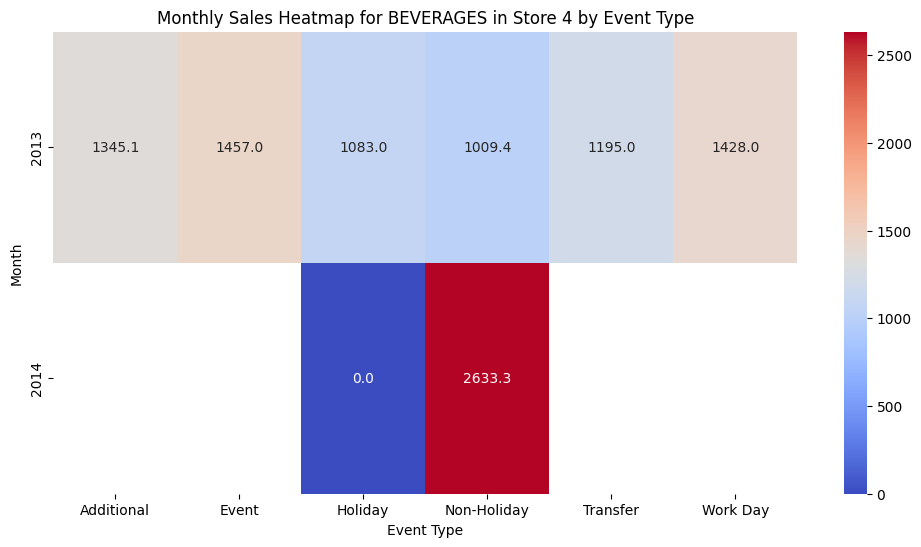

In [5]:
df_filtered = df[(df['store_nbr'] == store_nbr) & (df['family'] == product_family)]
df_filtered['month'] = df_filtered['date'].dt.month
df_filtered['year'] = df_filtered['date'].dt.year

pivot_table = df_filtered.pivot_table(index='year', columns='type', values='sales', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".1f")

plt.title(f"Monthly Sales Heatmap for {product_family} in Store {store_nbr} by Event Type")
plt.ylabel("Month")
plt.xlabel("Event Type")
plt.show()

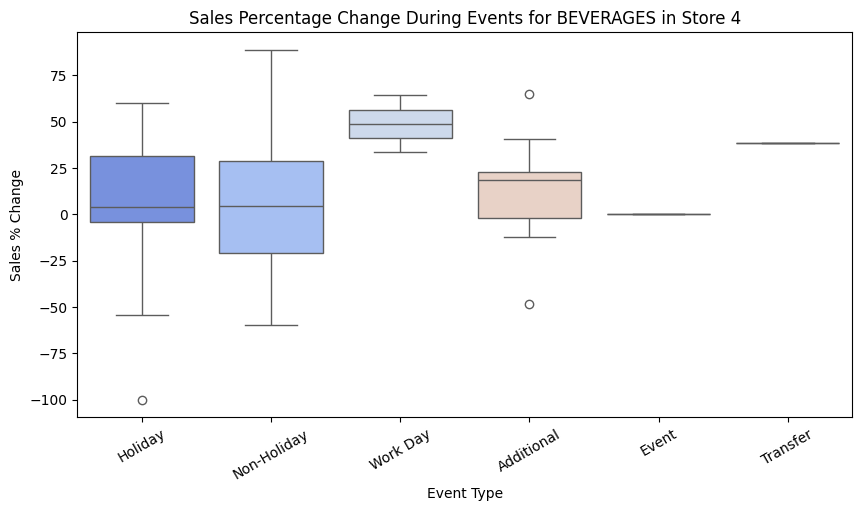

In [6]:
df_filtered['sales_pct_change'] = df_filtered['sales'].pct_change() * 100  # Convert to percentage

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_filtered, x='type', y='sales_pct_change', palette="coolwarm")

plt.xlabel("Event Type")
plt.ylabel("Sales % Change")
plt.title(f"Sales Percentage Change During Events for {product_family} in Store {store_nbr}")
plt.xticks(rotation=30)
plt.show()


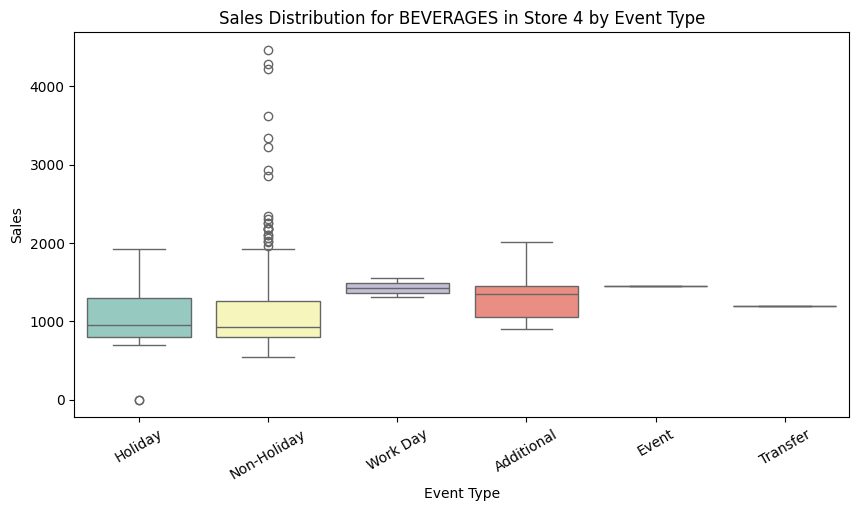

In [7]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_filtered, x='type', y='sales', palette="Set3")

plt.xlabel("Event Type")
plt.ylabel("Sales")
plt.title(f"Sales Distribution for {product_family} in Store {store_nbr} by Event Type")
plt.xticks(rotation=30)
plt.show()


In [8]:
df = pd.concat([df_train, df_test])
# Merge train data with oil prices
df = pd.merge(df, df_oil, on='date', how='left')
df['dcoilwtico'] = df['dcoilwtico'].fillna(0)
# Merge with store information
df = pd.merge(df, df_stores, on='store_nbr', how='left')
df = pd.merge(df, df_transaction, on=['date', 'store_nbr'], how='left')
df.transactions = df.transactions.fillna(0)
# Merge with holidays and events
for holiday in df_holidays_events['type'].unique():
     df[f'holiday_{holiday}'] = (df['date'].isin(df_holidays_events[df_holidays_events['type'] == holiday]['date'])).astype(int)

In [9]:
df.drop(columns=['id', 'city', 'state'], inplace=True)

### Categorical features encoding

In [10]:
label_encoder = OneHotEncoder(sparse_output=False , handle_unknown='ignore')
categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(include=['number','datetime']).columns
#for feature in label_features:
encoded_features= label_encoder.fit_transform(df[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=label_encoder.get_feature_names_out(categorical_features))
# Concatenate numerical and encoded features:
df_encoded = pd.concat([df[numerical_features], encoded_df], axis=1)
df_encoded.head()


,date,store_nbr,sales,onpromotion,dcoilwtico,cluster,transactions,holiday_Holiday,holiday_Transfer,holiday_Additional,holiday_Bridge,holiday_Work Day,holiday_Event,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,type_A,type_B,type_C,type_D,type_E
0,2013-01-01,1,0.00,0,0.00,13,0.00,1,0,0,0,0,0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,2013-01-01,1,0.00,0,0.00,13,0.00,1,0,0,0,0,0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,2013-01-01,1,0.00,0,0.00,13,0.00,1,0,0,0,0,0,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,2013-01-01,1,0.00,0,0.00,13,0.00,1,0,0,0,0,0,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,2013-01-01,1,0.00,0,0.00,13,0.00,1,0,0,0,0,0,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [11]:
data_train = df_encoded[:len(df_train)]
data_test =  df_encoded[len(df_train):]

In [12]:
print(f"Number train data: {len(data_train)}")
print(f"Number test data: {len(data_test)}")

Number train data: 691099
Number test data: 28512


In [13]:
### Define metrics for evaluating the prediction model
# mean absolute squared error
def mase(y_true, y_pred, y_train):
    naive_forecast = y_train[:-1]  # naive forecast: previous value
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    mase = mean_absolute_error(y_true, y_pred) / mae_naive
    return mase

### Split data into Train and Valide data

### Cross validation for time series analaysis

In [14]:
X = data_train.drop(['date', 'sales'], axis=1)
y = data_train['sales']
rf =  RandomForestRegressor(n_estimators=200, min_samples_split=5, n_jobs=-1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
rf.fit(X_train, y_train)
print("model has been fitted with train data")

model has been fitted with train data


In [15]:
#evaluate trained model
y_pred = rf.predict(X_val)
for i, val in enumerate(y_pred):
    if val < 0:
        y_pred[i] = 0
print(f"mean squared logarithm error: {mean_squared_log_error(y_val, y_pred)}")
print(f"R Sccore model score: {r2_score(y_val, y_pred)}")
print(f"mean absolute error: {mean_absolute_error(y_val, y_pred)}")
print(f"mean squared error: {mean_squared_error(y_val, y_pred)}")
print(f"mase: {mase(y_val, y_pred, y_val)}")

mean squared logarithm error: 1.109924787635122
R Sccore model score: 0.7755846028921412
mean absolute error: 90.89522737908707
mean squared error: 202316.88762875553
mase: 0.192224395715636


In [ ]:
X_test = data_test.drop(['date','sales'],axis=1)
y_test= rf.predict(X_test)
for i, val in enumerate(y_test):
    if val < 0:
        y_test[i] = 0
df_test['sales'] = y_test
df_test['date'] =  data_test['date'].values
df_test.head()

#### visualize performance in each cluster

In [16]:
df_train = pd.merge(df_train, df_stores, on='store_nbr', how='left')
df_test = pd.merge(df_test, df_stores, on='store_nbr', how='left')

In [ ]:
# Choose a specific cluster and product family
cluster = 1
product_family = "AUTOMOTIVE"  # Change this to any product category
df_filtered = df_train[(df_train['cluster'] == cluster) & (df_train['family'] == product_family)]
df_filtered_2 = df_test[(df_test['cluster'] == cluster) & (df_test['family'] == product_family)]
plt.figure(figsize=(15, 10))
# Plot sales over time
sns.lineplot(data=df_filtered, x='date', y='sales', label='Train data', color=sns.color_palette()[0])
sns.lineplot(data=df_filtered_2, x='date', y='sales', label='Test data', color=sns.color_palette()[1])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"Sales Trend for {product_family} for all stores in cluster {cluster}")
plt.show()

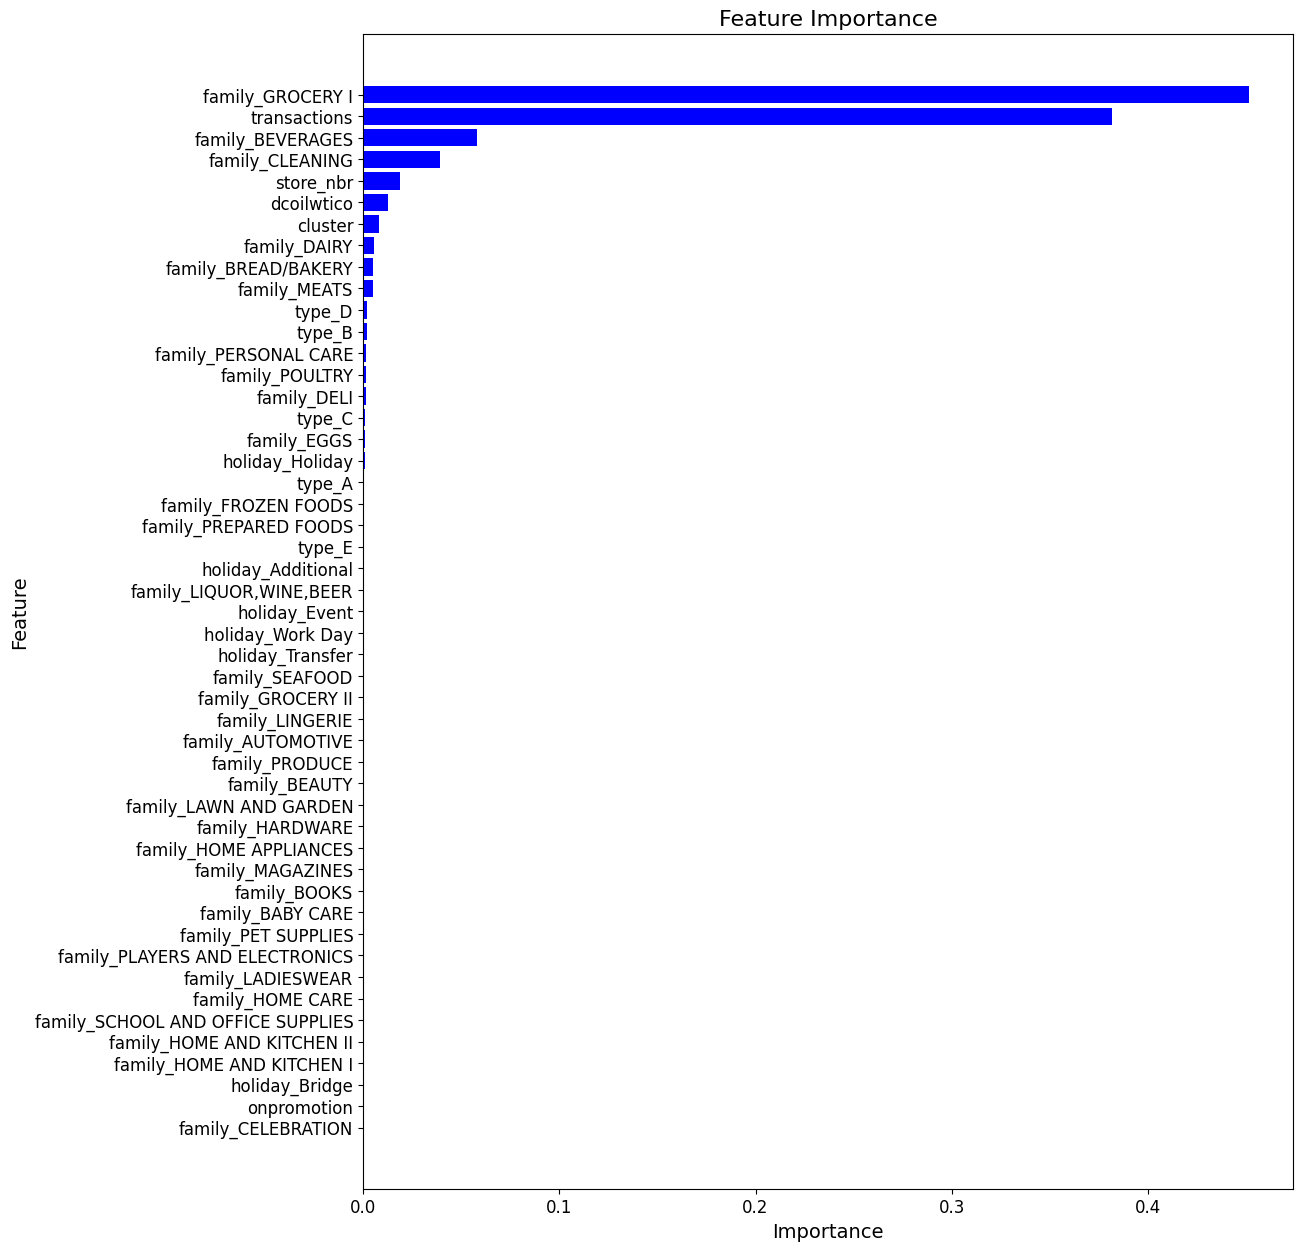

In [19]:
# Get Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 15))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='blue')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance', fontsize=16)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)  # Adjust x-axis font size
plt.yticks(fontsize=12)  # Adjust y-axis font size
plt.show()

#### remove features with low importance

In [20]:
low_importance_features = feature_importance[feature_importance['Importance'] < 0.05]['Feature'].tolist()
X_train_filtered = X_train.drop(columns=low_importance_features)
X_val_filtered = X_val.drop(columns=low_importance_features)

rf_filtered = RandomForestRegressor(n_estimators=200, min_samples_split=5, n_jobs=-1, random_state=42)
rf_filtered.fit(X_train_filtered, y_train)
y_pred_filtered = rf_filtered.predict(X_val_filtered)

print("score after removing feature with low importance:", rf_filtered.score(X_val_filtered, y_val))


score after removing feature with low importance: 0.6741100883646274


#### visualize correlation between features and target

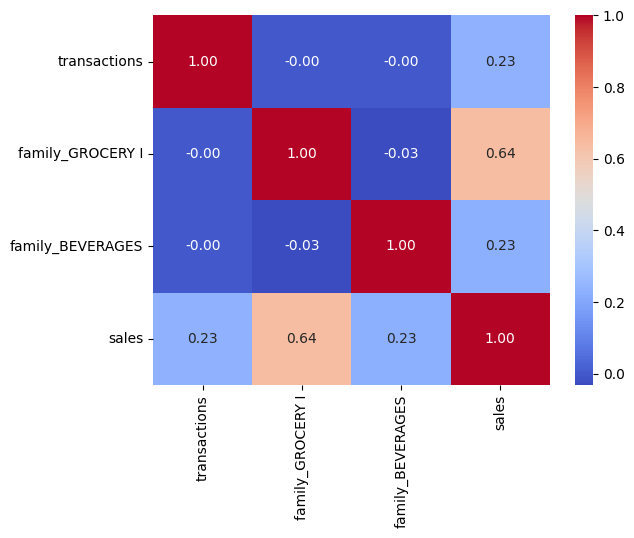

In [21]:
corr_matrix = X[['transactions','family_GROCERY I','family_BEVERAGES']].join(y).corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

Steps to implement ARIMA:

Data preparation:

Ensure your data is a time series with a consistent frequency (e.g., daily, weekly, monthly).
If necessary, handle missing values and outliers.
Make the time series stationary (if it's not already) by applying differencing or transformations.
Identify model order (p, d, q):

- p: Order of the autoregressive (AR) model (uses past values).
- d: Order of differencing (to make the series stationary).
- q: Order of the moving average (MA) model (uses past forecast errors).
Use techniques like ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots to determine the appropriate values for p, d, and q.
Fit the ARIMA model:

Use the statsmodels library in Python to fit the ARIMA model to your data using the identified order (p, d, q).
Make predictions:

Use the fitted model to forecast future sales values.
Evaluate the model:

Use metrics like RMSE, MAE, or MAPE to evaluate the accuracy of the predictions on a validation set.

### Prophet


In [11]:
#check missing values
df_train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [12]:
#check missing sales days in training
data_range_train = pd.date_range(start=df_train['date'].min(), end=df_train['date'].max(), freq='D')
missing_date = data_range_train .difference(df_train['date'])
if len(missing_date) == 0:
   print("No missing data")
else:
    print(f"total number of missing date: {len(missing_date)}")

total number of missing date: 4


In [13]:
#check missing sales days in test
data_range_test = pd.date_range(start=df_test['date'].min(), end=df_test['date'].max(), freq='D')
missing_date = data_range_test.difference(df_test['date'])
if len(missing_date) == 0:
   print("No missing data")
else:
    print(f"total number of missing date: {len(missing_date)}")

No missing data


In [14]:
#fill missing sales
df_train_full = pd.DataFrame({'date': data_range_train})
df_train_full = df_train_full.merge(df_train, on='date', how='left')
df_train_full = df_train_full.fillna(0)
df_train_full.sort_values(by='date', inplace=True)
df_train_full.head()

,date,id,store_nbr,family,sales,onpromotion
0,2013-01-01,0.00,1.00,AUTOMOTIVE,0.00,0.00
1194,2013-01-01,1194.00,42.00,CELEBRATION,0.00,0.00
1193,2013-01-01,1193.00,42.00,BREAD/BAKERY,0.00,0.00
1192,2013-01-01,1192.00,42.00,BOOKS,0.00,0.00
1191,2013-01-01,1191.00,42.00,BEVERAGES,0.00,0.00


In [15]:
df_train_full = pd.merge(df_train_full, df_stores, on='store_nbr', how='left')
df_test = pd.merge(df_test, df_stores, on='store_nbr', how='left')

In [17]:
split_index = int(len(df_train_full) * 0.8)
train_data = df_train_full[:split_index]
test_data = df_train_full[split_index:]

In [18]:
#group by family , cluster and date
df_train_grouped = train_data.groupby(by =['date','cluster', 'family'])['sales'].sum().reset_index()
df_train_grouped.head()

,date,cluster,family,sales
0,2013-01-01,1.00,AUTOMOTIVE,0.00
1,2013-01-01,1.00,BABY CARE,0.00
2,2013-01-01,1.00,BEAUTY,2.00
3,2013-01-01,1.00,BEVERAGES,810.00
4,2013-01-01,1.00,BOOKS,0.00


In [19]:
# Définition des colonnes à garder pour le groupby
groupby_cols = ['date', 'cluster', 'family']

# Suppression des colonnes non nécessaires dans df_test et test_data
df_test_filtered = df_test[groupby_cols].copy()
test_data_filtered = test_data[groupby_cols].copy()

# Concaténation et regroupement
df_test_grouped = pd.concat([test_data_filtered, df_test_filtered]).groupby(groupby_cols, as_index=False).sum()

# Vérification du résultat
df_test_grouped.head()


,date,cluster,family
0,2016-09-12,1.00,AUTOMOTIVE
1,2016-09-12,1.00,BABY CARE
2,2016-09-12,1.00,BEAUTY
3,2016-09-12,1.00,BEVERAGES
4,2016-09-12,1.00,BOOKS


In [20]:
holiday_df = df_holidays_events[['date', 'type']].drop_duplicates()
holiday_df.rename(columns={'date':'ds', 'type':'holiday'}, inplace=True)
holiday_df['lower_window'] = 0
holiday_df['upper_window'] = 1
holiday_df.head()

,ds,holiday,lower_window,upper_window
0,2012-03-02,Holiday,0,1
1,2012-04-01,Holiday,0,1
2,2012-04-12,Holiday,0,1
3,2012-04-14,Holiday,0,1
4,2012-04-21,Holiday,0,1


In [ ]:
from prophet import Prophet
from multiprocessing import Pool, cpu_count
import os

def train_predict_prophet(args):
    cluster, family, train_df, test_df, holiday_df= args

    # Filter data for specific cluster and family
    train_data = train_df[(train_df['cluster'] == cluster) & (train_df['family'] == family)].reset_index(drop=True)
    test_data = test_df[(test_df['cluster'] == cluster) & (test_df['family'] == family)]
    print("Training data shape:", train_data.shape)
    print("Test data shape:", test_data.shape)
    # Prophet requires 'ds' and 'y' columns
    train_data = train_data.rename(columns={'date': 'ds', 'sales': 'y'})
    train_data = train_data[['ds','y']]

    # Initialize and fit the Prophet model
    model = Prophet(interval_width=0.95, holidays=holiday_df)
    model.fit(train_data)

    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=len(test_data))

    # Make predictions
    forecast = model.predict(future)

    # Save the plot as an image file
    # Create the directory if it doesn't exist
    directory = f'cluster_{cluster}_family_{family}'  # Directory name
    os.makedirs(directory, exist_ok=True)  # Create if not exists

    # Save the plot as an image file to the created directory
    #fig = model.plot(forecast)
    #plt.title(f'Cluster {cluster} - Family {family}')
    #file_path = os.path.join(directory, f'cluster_{cluster}_family_{family}.png')  # Save plot to file
    #fig.savefig(file_path)
    #plt.close(fig)  # Close the figure to release resources

    # Extract predictions for the test period
    predictions = forecast[['ds', 'yhat']][-len(test_data):].rename(columns={'ds': 'date', 'yhat': 'sales'})
    predictions = pd.merge(predictions, test_data, on='date', how='left')

    return predictions

if __name__ == '__main__':  # Important for multiprocessing
    # Prepare the arguments for multiprocessing
    groups = []
    for cluster in df_train_grouped.cluster.unique():
      for family in df_train_grouped.family.unique():
          groups.append((cluster, family, df_train_grouped, df_test_grouped, holiday_df))

    # Use multiprocessing to run the model on each cluster/family group
    with Pool(processes=cpu_count()) as pool:
        results = pool.map(train_predict_prophet, groups)

    # Combine the results
    final_predictions = pd.concat(results)

    # Ensure predictions are not negative
    final_predictions['sales'] = np.maximum(0, final_predictions['sales'])

    final_predictions.to_csv('prophet_submission.csv', index=False)


In [48]:
result = pd.read_csv('prophet_submission.csv')

In [55]:
result['date'] = pd.to_datetime(result['date'])

In [64]:
df_val =  df_train_full[split_index:].groupby(by =['date','cluster', 'family'])['sales'].sum().reset_index()
df_val.sort_values(by='family', inplace=True)
df_val

,date,cluster,family,sales
0,2016-09-12,1.00,AUTOMOTIVE,6.00
126212,2017-04-26,2.00,AUTOMOTIVE,7.00
126179,2017-04-26,1.00,AUTOMOTIVE,11.00
16289,2016-10-11,3.00,AUTOMOTIVE,28.00
126146,2017-04-25,17.00,AUTOMOTIVE,11.00
...,...,...,...,...
79285,2017-02-01,7.00,SEAFOOD,7.00
5167,2016-09-21,5.00,SEAFOOD,97.51
79252,2017-02-01,6.00,SEAFOOD,70.10
4936,2016-09-20,15.00,SEAFOOD,22.00


In [63]:
df_result = result[result.date.isin(df_val.date)].reset_index(drop=True)
df_result

,date,sales,cluster,family
0,2016-09-12,11.78,1.00,AUTOMOTIVE
1,2016-09-13,11.40,1.00,AUTOMOTIVE
2,2016-09-14,11.07,1.00,AUTOMOTIVE
3,2016-09-15,11.36,1.00,AUTOMOTIVE
4,2016-09-16,12.29,1.00,AUTOMOTIVE
...,...,...,...,...
188797,2017-08-11,65.05,17.00,SEAFOOD
188798,2017-08-12,55.15,17.00,SEAFOOD
188799,2017-08-13,67.84,17.00,SEAFOOD
188800,2017-08-14,55.19,17.00,SEAFOOD


In [70]:
# and fill missing values with 0
merged_df = pd.merge(df_val, df_result, on=['date', 'cluster', 'family'], how='outer').fillna(0)

# Now, extract y_true and y_pred from the merged DataFrame
y_true = merged_df['sales_x'].values  # Sales from df_val
y_pred = merged_df['sales_y'].values  # Sales from df_result

# Calculate the mean squared logarithm error
print(f"mean squared logarithm error: {mean_squared_log_error(y_true, y_pred)}")
print(f"R Sccore model score: {r2_score(y_true, y_pred)}")
print(f"mean absolute error: {mean_absolute_error(y_true, y_pred)}")
print(f"mean squared error: {mean_squared_error(y_true, y_pred)}")
print(f"mase: {mase(y_true, y_pred, y_true)}")

mean squared logarithm error: 0.8692414786532108
R Sccore model score: 0.9244539533329716
mean absolute error: 311.0258358541255
mean squared error: 1387378.330280591
mase: 0.12099156262839099


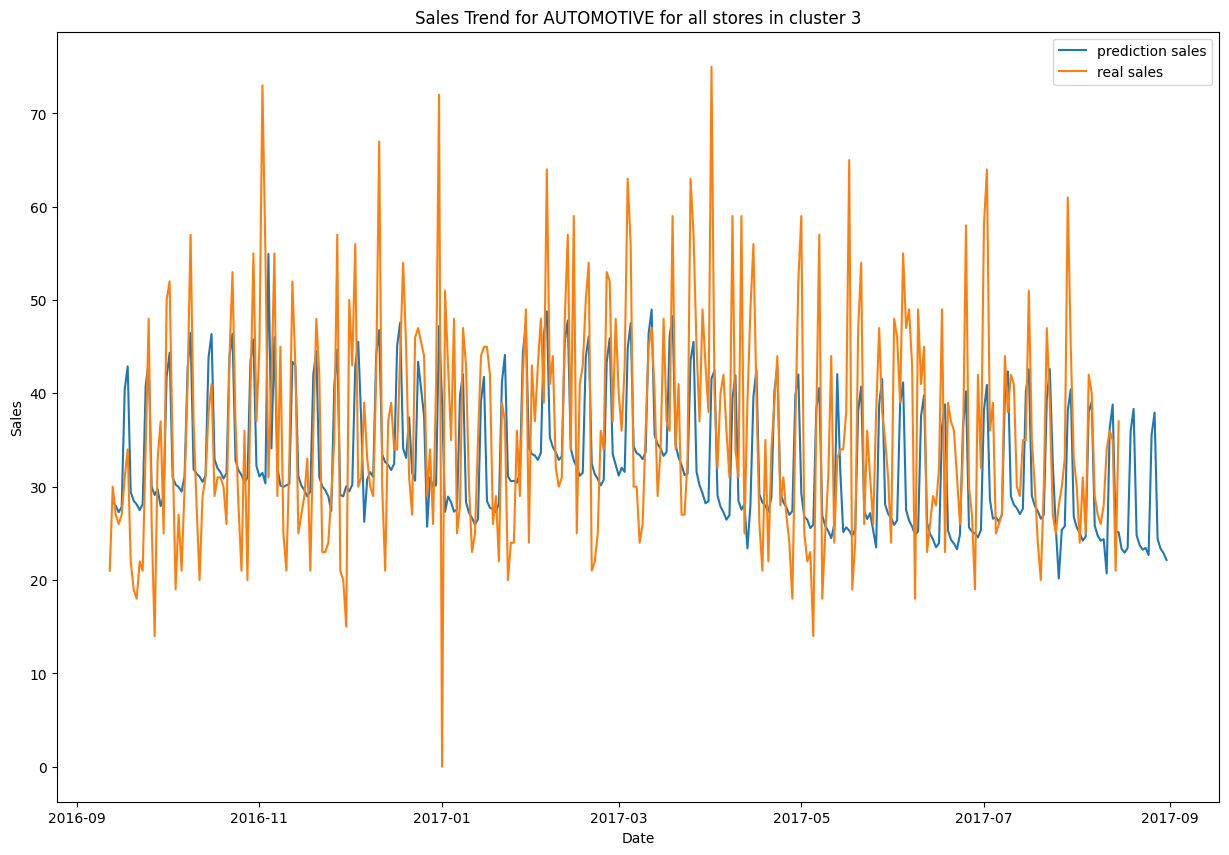

In [75]:
cluster = 3
product_family = "AUTOMOTIVE"  # Change this to any product category
df_filtered = result[(result['cluster'] == cluster) & (result['family'] == product_family)]
df_filtered_2 = df_val[(df_val['cluster'] == cluster) & (df_val['family'] == product_family)]
plt.figure(figsize=(15, 10))
# Plot sales over time
sns.lineplot(data=df_filtered, x='date', y='sales', label='prediction sales', color=sns.color_palette()[0])
sns.lineplot(data=df_filtered_2, x='date', y='sales', label='real sales', color=sns.color_palette()[1])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title(f"Sales Trend for {product_family} for all stores in cluster {cluster}")
plt.show()